# Importing Libraries

In [ ]:
# İmporting Library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
import shap
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.pipeline import Pipeline as imba_Pipeline
from sklearn.pipeline import Pipeline
import joblib


In [380]:
# Load the datasets
loan_data = pd.read_csv('/Users/yasirkeskin/rpaa-recruiting-case-yasirkeskin/data/loan_data.csv',sep=',')
customer_data = pd.read_csv('/Users/yasirkeskin/rpaa-recruiting-case-yasirkeskin/data/customer_data.csv',sep=',')
customer_financials = pd.read_csv('/Users/yasirkeskin/rpaa-recruiting-case-yasirkeskin/data/customer_financials.csv',sep=';')
loan_delinquencies = pd.read_csv('/Users/yasirkeskin/rpaa-recruiting-case-yasirkeskin/data/loan_deliquencies.csv',sep=',')


# Data Analysis Outcomes
## LOAN_DATA
### Structure: 
- The dataset contains 40,000 records and 9 columns, with no missing values. This indicates completeness and readiness for analysis.
### Observations:
- The loan_reason has 4 unique values, dominated by "Car" loans (16,043 occurrences).
- Loan terms range from 24 to 72 months, with a mean of ~48 months.
- The requested loan amounts vary from 2,000 to 50,000, with an average of ~12,934.
- There are customers with up to 7 loan accounts, though the median is 0.
### Potential Issues:
- The date column is in object type, which might need conversion to datetime for temporal analysis.
- Data might be skewed for installment and requested amounts due to large standard deviations.
## CUSTOMER_DATA
### Structure: 
- This dataset also contains 40,000 records across 9 columns, with no missing values.
### Observations:
- The majority of customers are male (27,878), and the most frequent employment type is "Private Sector" (15,939).
- Birth dates have 478 unique values, potentially indicating data clustering around common dates or defaults.
- joined_ING_date has repeated dates (top is March 1, 2015, with 938 occurrences), possibly showing a trend in customer onboarding.
### Potential Issues:
- Dates like birth_date and joined_ING_date need conversion to datetime for calculations (e.g., customer age or tenure).
- Religious distribution shows 5 unique categories, with "U" (unspecified?) being the most common.
## CUSTOMER_FINANCIALS
### Structure: 
- This dataset is significantly larger, with 1,324,872 records and 6 columns, but it has missing data in financial columns (salary, current_acc_balance, etc.).
### Observations:
- 26.4% of salary data is missing, which could bias financial analyses.
- Credit card balances are available for only ~40% of the data, with some negative values that may need investigation.
- Account balances have wide ranges, from negative values to over 20,000, reflecting diverse financial situations.
### Potential Issues:
- Missing values in salary and account balances need to be handled (e.g., imputation or exclusion).
- Negative values in current_acc_balance and credit_card_balance could indicate overdrafts or data errors.
## LOAN_DELINQUENCIES
### Structure: 
- A smaller dataset with 15,285 records and 3 columns, with no missing values.
### Observations:
- The start_date and end_date indicate loan delinquency periods, with 45 and 48 unique values, respectively.
- The dataset is likely linked to loan_id, suggesting a subset of loans that went delinquent.
### Potential Issues:
- Dates are in object type and need conversion for duration calculations.
- Further analysis is required to correlate delinquency data with loan and customer attributes.

In [381]:
# Quick exploration of each dataset
datasets = {'loan_data': loan_data, 'customer_data': customer_data,
            'customer_financials': customer_financials, 'loan_delinquencies': loan_delinquencies}

for name, data in datasets.items():
    print(f"\n--- {name.upper()} ---")
    print(data.info())
    print(data.describe(include='all'))
    print(data.isnull().sum())



--- LOAN_DATA ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   loan_id                40000 non-null  int64  
 1   cust_id                40000 non-null  int64  
 2   date                   40000 non-null  object 
 3   loan_reason            40000 non-null  object 
 4   loan_term              40000 non-null  int64  
 5   requested_amount       40000 non-null  int64  
 6   installment            40000 non-null  float64
 7   number_loans_accounts  40000 non-null  int64  
 8   number_accounts        40000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 2.7+ MB
None
              loan_id      cust_id        date loan_reason     loan_term  \
count    40000.000000  40000.00000       40000       40000  40000.000000   
unique            NaN          NaN          36           4           NaN   
top   

# Data Explorations and Wrangling

In [382]:
# Define a function to convert specified columns to datetime
def convert_to_datetime(df, columns):
    """
    Converts specified columns in a DataFrame to datetime format.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the columns to convert.
        columns (list): List of column names to convert.
        
    Returns:
        pd.DataFrame: DataFrame with updated datetime columns.
    """
    for column in columns:
        df[column] = pd.to_datetime(df[column], errors='coerce')  # Robustness: handles invalid dates
    return df

# Specify columns to convert for each DataFrame
datetime_columns = {
    "LOAN_DATA": ['date'],
    "CUSTOMER_DATA": ['birth_date', 'joined_ING_date'],
    "CUSTOMER_FINANCIALS": ['date'],
    "LOAN_DELINQUENCIES": ['start_date', 'end_date']
}

# Convert date columns using the function
loan_data = convert_to_datetime(loan_data, datetime_columns['LOAN_DATA'])
customer_data = convert_to_datetime(customer_data, datetime_columns['CUSTOMER_DATA'])
customer_financials = convert_to_datetime(customer_financials, datetime_columns['CUSTOMER_FINANCIALS'])
loan_delinquencies = convert_to_datetime(loan_delinquencies, datetime_columns['LOAN_DELINQUENCIES'])



Merged Data Missing Values:
loan_id                             0
cust_id                             0
date                                0
loan_reason                         0
loan_term                           0
requested_amount                    0
installment                         0
number_loans_accounts               0
number_accounts                     0
gender                              0
religion                            0
employment                          0
postal_code                         0
birth_date                          0
joined_ING_date                     0
number_client_calls_to_ING          0
number_client_calls_from_ING        0
salary                           7975
current_acc_balance              1230
saving_acc_balance               3175
credit_card_balance             23979
start_date                      24715
end_date                        24715
dtype: int64


/var/folders/lc/g7yc0rk916j0sbdq69rl9r380000gn/T/ipykernel_8470/2272320470.py:53: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


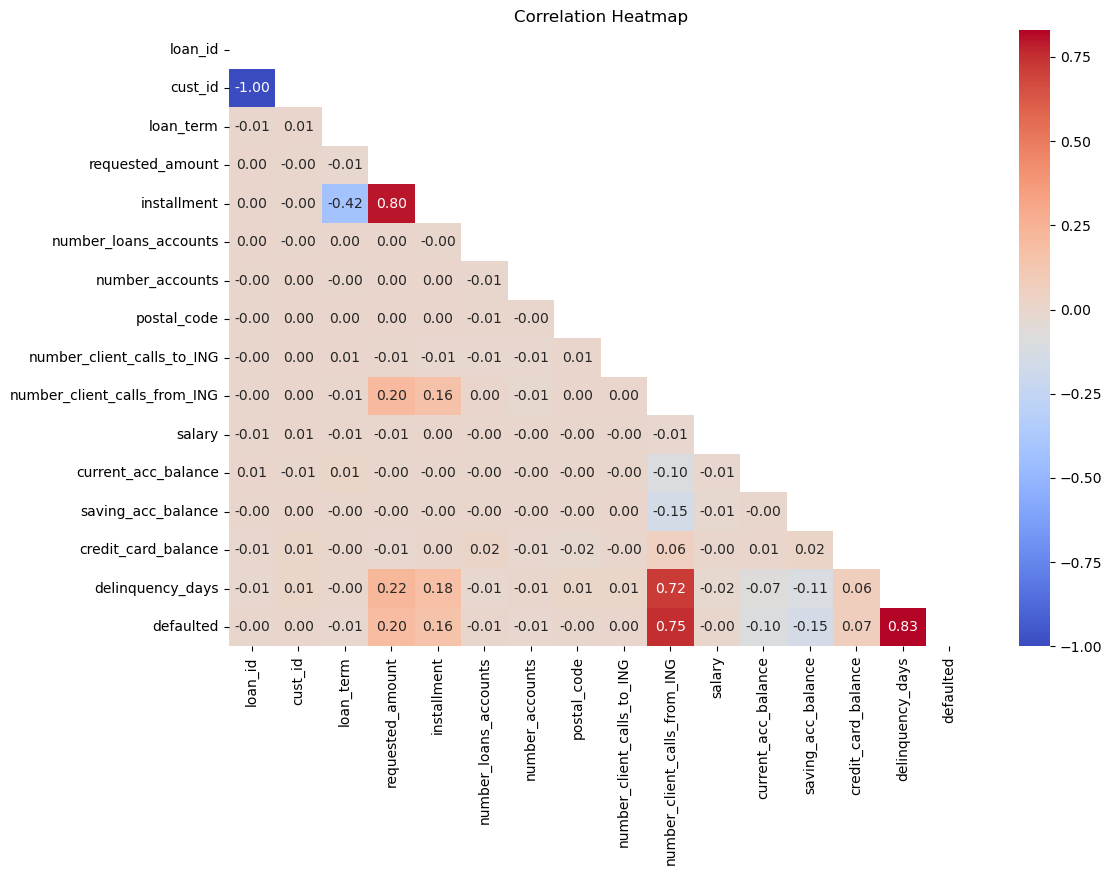

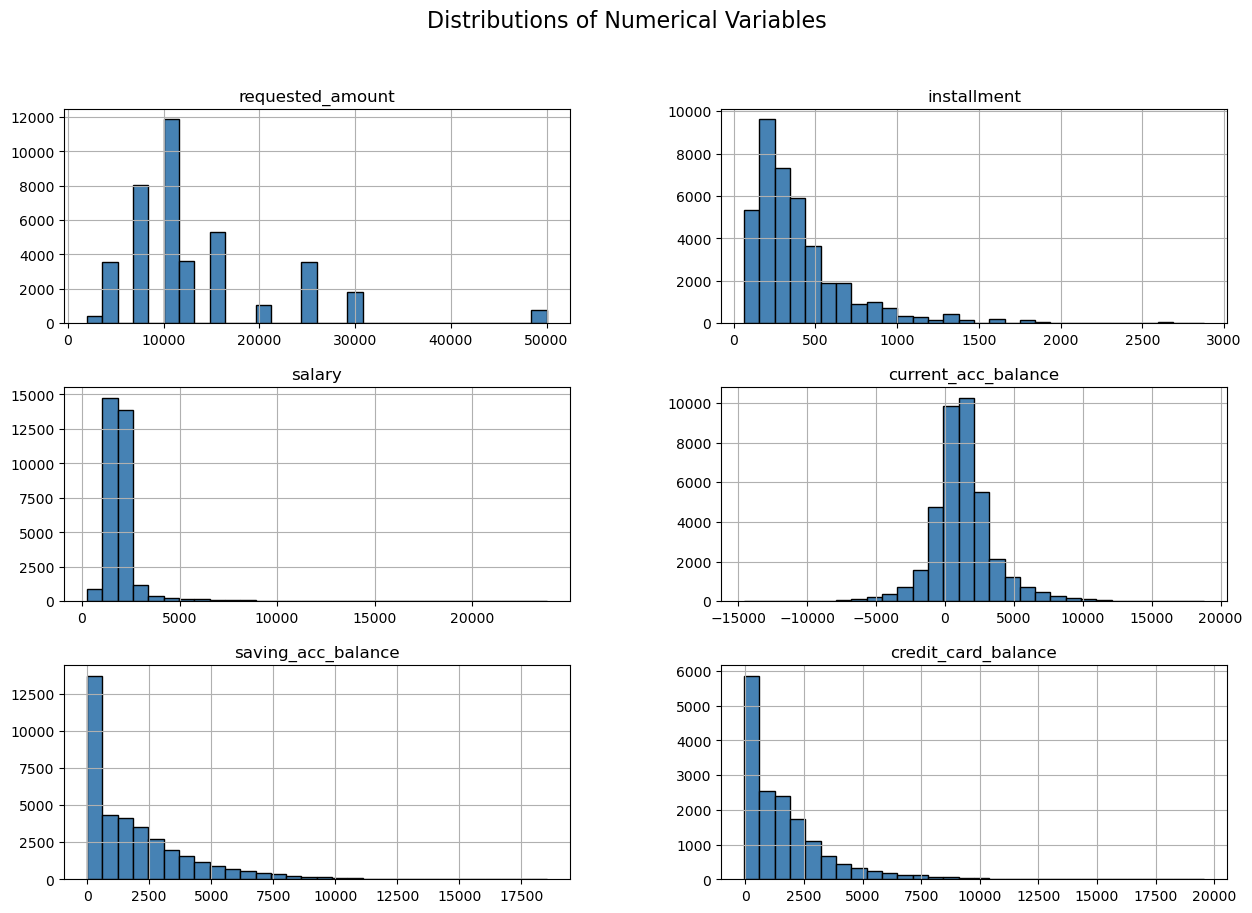

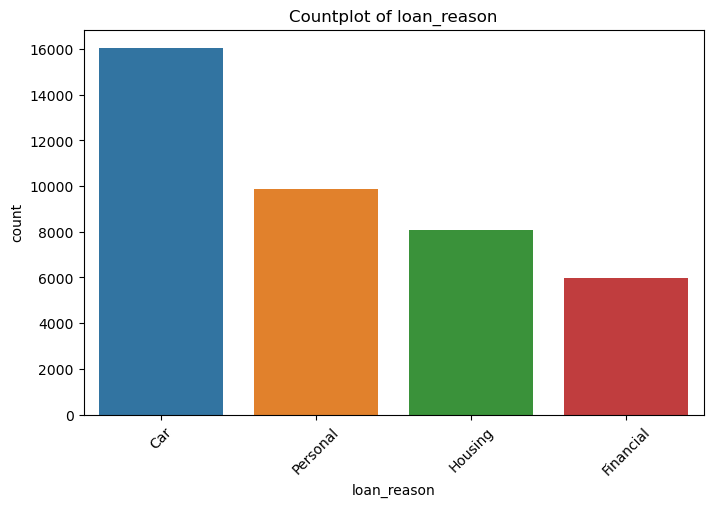

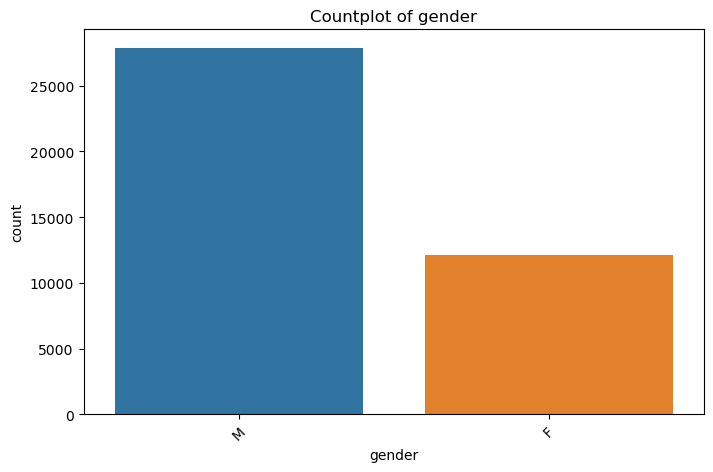

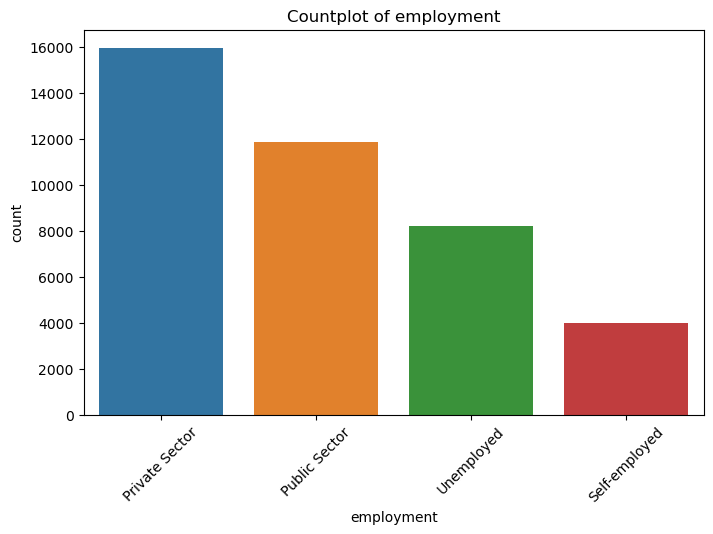

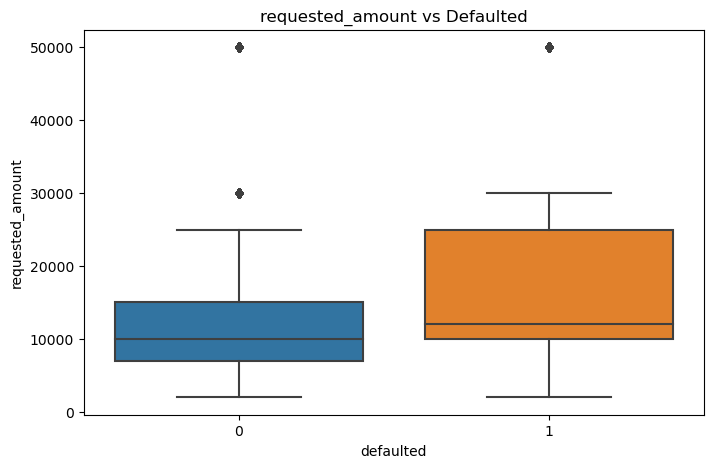

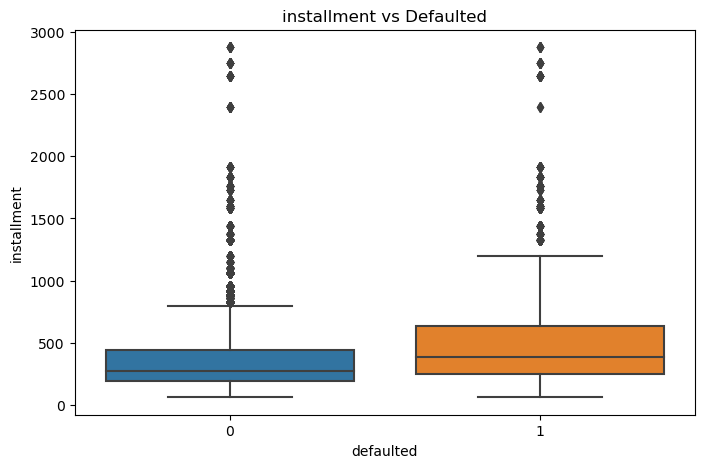

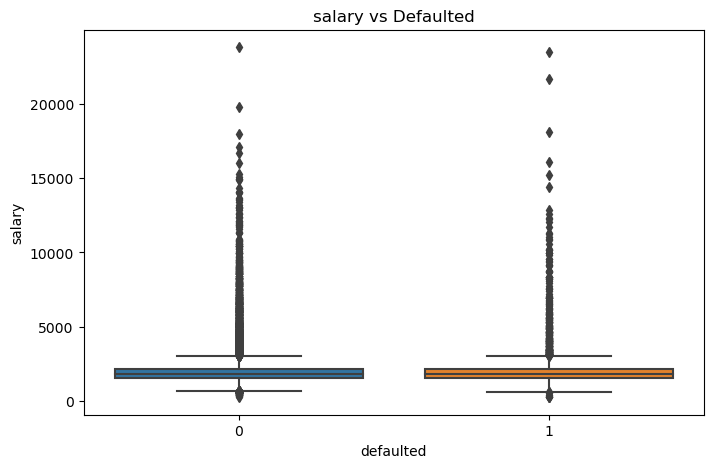

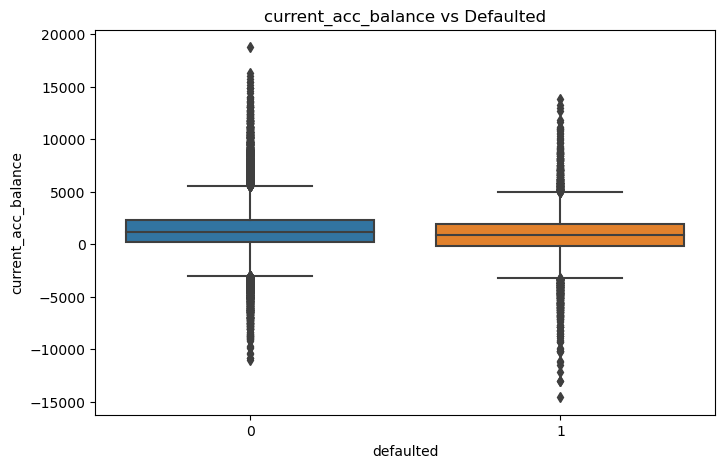

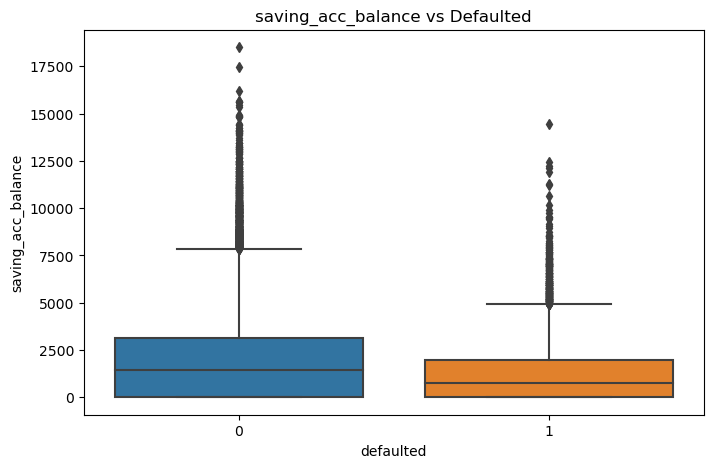

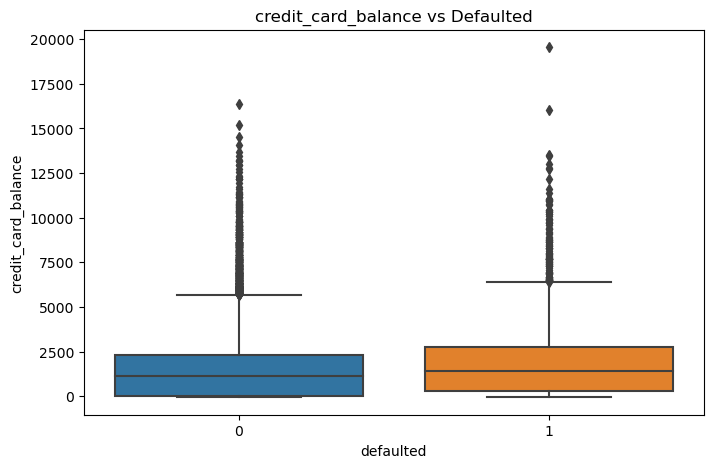

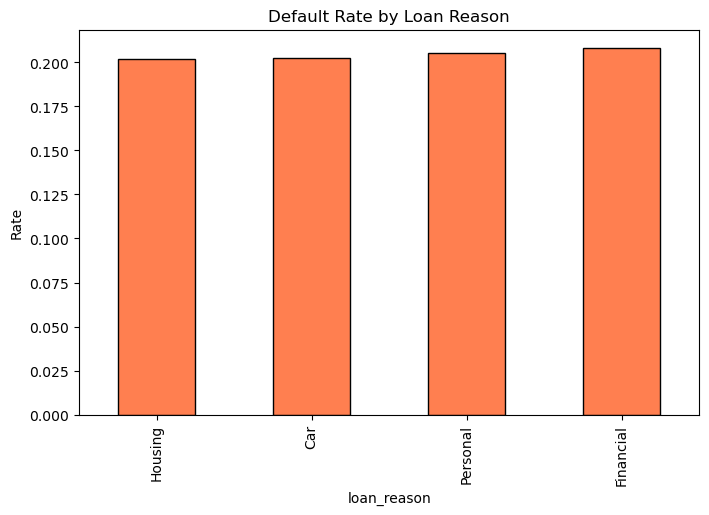

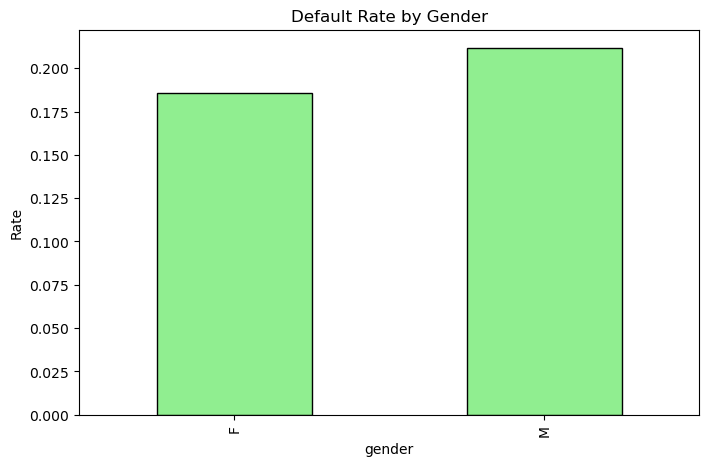

In [383]:

# Function to merge datasets
def merge_datasets(dataframes, merge_info):
    """
    Merges multiple datasets sequentially based on specified keys and join types.

    Parameters:
        dataframes (dict): Dictionary with DataFrame names as keys and DataFrames as values.
        merge_info (list): List of dictionaries containing merge details:
                           {'left': <left_df>, 'right': <right_df>, 'on': <merge_keys>, 'how': <join_type>}

    Returns:
        pd.DataFrame: Merged DataFrame.
    """
    merged_df = dataframes[merge_info[0]['left']]
    for info in merge_info:
        merged_df = merged_df.merge(
            dataframes[info['right']],
            on=info['on'],
            how=info['how']
        )
    return merged_df

# Prepare data for merging
dataframes = {
    "loan_data": loan_data,
    "customer_data": customer_data,
    "customer_financials": customer_financials,
    "loan_delinquencies": loan_delinquencies
}

merge_info = [
    {'left': 'loan_data', 'right': 'customer_data', 'on': 'cust_id', 'how': 'left'},
    {'left': 'loan_data', 'right': 'customer_financials', 'on': ['cust_id', 'date'], 'how': 'left'},
    {'left': 'loan_data', 'right': 'loan_delinquencies', 'on': 'loan_id', 'how': 'left'}
]

# Perform merging
merged_data = merge_datasets(dataframes, merge_info)

# Check for missing data after merging
print("\nMerged Data Missing Values:")
print(merged_data.isnull().sum())

# Exploratory Data Analysis (EDA)
def plot_correlation_heatmap(df, title="Correlation Heatmap"):
    """
    Plots a heatmap of correlations for numerical columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing numerical data.
        title (str): Title of the heatmap.
    """
    corr_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', mask=np.triu(corr_matrix))
    plt.title(title)
    plt.show()

def plot_numerical_distributions(df, columns, title="Distributions of Numerical Variables"):
    """
    Plots histograms for a list of numerical columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): List of numerical columns to plot.
        title (str): Title of the plot.
    """
    df[columns].hist(bins=30, figsize=(15, 10), color='steelblue', edgecolor='black')
    plt.suptitle(title, fontsize=16)
    plt.show()

def plot_categorical_counts(df, columns):
    """
    Plots count plots for a list of categorical columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): List of categorical columns to plot.
    """
    for col in columns:
        plt.figure(figsize=(8, 5))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Countplot of {col}")
        plt.xticks(rotation=45)
        plt.show()

# Define a function to derive Loan Performance
def compute_loan_performance(data):
    """
    Derive whether the loan defaulted based on loan delinquencies.
    Default: If delinquency exceeds 90 days, mark as 1; otherwise 0.
    """
    # Compute the days of delinquency
    data['delinquency_days'] = (pd.to_datetime(data['end_date']) - pd.to_datetime(data['start_date'])).dt.days
    data['defaulted'] = np.where(data['delinquency_days'] > 90, 1, 0)
    return data

merged_data = compute_loan_performance(merged_data)


# Correlation heatmap
plot_correlation_heatmap(merged_data, "Correlation Heatmap")

# Distributions of numerical variables
num_cols = [
    'requested_amount', 'installment', 'salary', 
    'current_acc_balance', 'saving_acc_balance', 'credit_card_balance'
]
plot_numerical_distributions(merged_data, num_cols)

# Analysis of categorical variables
cat_cols = ['loan_reason', 'gender', 'employment']
plot_categorical_counts(merged_data, cat_cols)

# Boxplot for defaulted vs numerical variables
def plot_boxplots(df, target_col, feature_cols):
    """
    Plots boxplots for a target column against a list of numerical feature columns.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        target_col (str): The column representing the target variable.
        feature_cols (list): List of feature columns to plot.
    """
    for col in feature_cols:
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df, x=target_col, y=col)
        plt.title(f"{col} vs {target_col.capitalize()}")
        plt.show()

plot_boxplots(merged_data, 'defaulted', num_cols)

# Grouping analysis
def plot_grouped_bar(df, group_col, target_col, title, color):
    """
    Plots a grouped bar chart showing the mean of a target column by group.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        group_col (str): Column to group by.
        target_col (str): Column to calculate mean values for.
        title (str): Title of the plot.
        color (str): Bar color.
    """
    grouped_data = df.groupby(group_col)[target_col].mean().sort_values()
    grouped_data.plot(kind='bar', figsize=(8, 5), color=color, edgecolor='black')
    plt.title(title)
    plt.ylabel("Rate")
    plt.show()

plot_grouped_bar(merged_data, 'loan_reason', 'defaulted', "Default Rate by Loan Reason", 'coral')
plot_grouped_bar(merged_data, 'gender', 'defaulted', "Default Rate by Gender", 'lightgreen')

# Save the merged data for further analysis
merged_data.to_csv('merged_data.csv', index=False)


# Outlier Handling

In [384]:

def detect_outliers(df, columns, method="zscore", threshold=3):
    """
    Detects outliers in specified columns using the chosen method.

    Parameters:
    df (pd.DataFrame): The input data.
    columns (list): List of column names to check for outliers.
    method (str): Method to detect outliers ('zscore' or 'iqr').
    threshold (float): Threshold value for detecting outliers.

    Returns:
    pd.DataFrame: DataFrame with an additional column indicating outliers.
    """
    outlier_flags = pd.DataFrame(index=df.index)
    
    for col in columns:
        if method == "zscore":
            z_scores = (df[col] - df[col].mean()) / df[col].std()
            outlier_flags[col] = np.abs(z_scores) > threshold
        
        elif method == "iqr":
            q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound, upper_bound = q1 - threshold * iqr, q3 + threshold * iqr
            outlier_flags[col] = (df[col] < lower_bound) | (df[col] > upper_bound)
        
        else:
            raise ValueError("Invalid method. Choose 'zscore' or 'iqr'.")
    
    df["Outlier"] = outlier_flags.any(axis=1)
    return df

def handle_outliers(df, columns, method="remove"):
    """
    Handles outliers in specified columns.

    Parameters:
    df (pd.DataFrame): The input data.
    columns (list): List of column names to handle outliers.
    method (str): How to handle outliers ('remove', 'cap', or 'replace').

    Returns:
    pd.DataFrame: DataFrame with handled outliers.
    """
    df = df.copy()
    
    for col in columns:
        if method == "remove":
            df = df[~df["Outlier"]]
        elif method == "cap":
            q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
            iqr = q3 - q1
            lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
            df[col] = np.clip(df[col], lower_bound, upper_bound)
        elif method == "replace":
            median_value = df[col].median()
            df.loc[df["Outlier"], col] = median_value
        else:
            raise ValueError("Invalid method. Choose 'remove', 'cap', or 'replace'.")
    
    return df.drop(columns=["Outlier"])


In [385]:
# Example to detect and handle outliers
num_cols_for_outliers = ['requested_amount', 'installment', 'salary', 'credit_card_balance', 'saving_acc_balance', 'current_acc_balance']

# Detect outliers
merged_data = detect_outliers(merged_data, columns=num_cols_for_outliers, method="zscore", threshold=3)

# Handle outliers by removing them
merged_data = handle_outliers(merged_data, columns=num_cols_for_outliers, method="remove")

# Or alternatively, handle outliers by capping or replacing them
# df_cleaned = handle_outliers(df, columns=num_cols_for_outliers, method="cap")
# df_cleaned = handle_outliers(df, columns=num_cols_for_outliers, method="replace")


# Feature Engineering

In [386]:

# Define a function to compute Customer Risk Profile
def compute_risk_profile(data):
    """
    Compute the ratio of installment to salary (Customer Risk Profile).
    """
    data['risk_profile'] = data['installment'] / (data['salary'] + 1e-6)  # Avoid division by zero
    return data

# Define a function to compute Debt-to-Income Ratio (DTI)
def compute_dti(data):
    """
    Compute the Debt-to-Income Ratio (DTI) as:
    (sum of all debt balances) / (salary + savings)
    """
    total_debt = data[['installment', 'credit_card_balance']].sum(axis=1)
    total_income = data['salary'] + data['saving_acc_balance']
    data['dti'] = total_debt / (total_income + 1e-6)  # Avoid division by zero
    return data

# Define a function to calculate trends in account balances or calls (Account Activity)
def compute_account_activity(data):
    """
    Calculate account activity trends using rolling averages or simple changes over time.
    Requires sorted data by customer and date.
    """
    data = data.sort_values(by=['cust_id', 'date'])
    # Example: Rolling mean of current account balance (trend)
    data['current_account_trend'] = data['current_acc_balance'].transform(
        lambda x: x.diff().rolling(3).mean()
    )
    # Example: Change in calls to/from ING
    data['calls_to_ing_change'] = data['number_client_calls_to_ING'].transform(lambda x: x.diff())
    data['calls_from_ing_change'] = data['number_client_calls_from_ING'].transform(lambda x: x.diff())
    return data


# Apply the functions step by step
merged_data = compute_risk_profile(merged_data)
merged_data = compute_dti(merged_data)
merged_data = compute_account_activity(merged_data)


# Save the dataset with new features for reproducibility
merged_data.to_csv('merged_data_with_features.csv', index=False)

# Quick check for newly engineered features
print(merged_data[['risk_profile', 'dti', 'current_account_trend', 'calls_to_ing_change', 'calls_from_ing_change']].head())


   risk_profile       dti  current_account_trend  calls_to_ing_change  \
1           NaN       NaN                    NaN                  NaN   
2           NaN       NaN                    NaN                  0.0   
3      0.253194  0.253194                    NaN                  5.0   
4      0.021327  0.301955            -129.496667                 -5.0   
5           NaN       NaN            -148.383333                  0.0   

   calls_from_ing_change  
1                    NaN  
2                   -6.0  
3                    6.0  
4                   -6.0  
5                    4.0  


# Missing Values Handling

In [387]:
# Function to handle missing values for numerical columns
def handle_missing_numerical(df, impute_columns, strategy='median', fill_zero=None):
    """
    Handles missing values for numerical columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        impute_columns (list): List of columns to impute missing values for.
        strategy (str): Strategy for imputation ('mean', 'median', 'most_frequent', etc.).
        fill_zero (list, optional): List of columns to fill missing values with 0.
        
    Returns:
        pd.DataFrame: DataFrame with missing values handled.
    """
    # Impute specified columns with chosen strategy
    if impute_columns:
        imputer = SimpleImputer(strategy=strategy)
        df[impute_columns] = imputer.fit_transform(df[impute_columns])
    
    # Fill specified columns with zero
    if fill_zero:
        df[fill_zero] = df[fill_zero].fillna(0)
    
    return df

# Define columns for handling missing values
impute_median_columns = ['salary', 'current_acc_balance', 'saving_acc_balance','delinquency_days']
fill_zero_columns = ['credit_card_balance','risk_profile','dti','current_account_trend','calls_to_ing_change','calls_from_ing_change']

# Handle missing values
merged_data = handle_missing_numerical(
    df=merged_data,
    impute_columns=impute_median_columns,
    strategy='median',
    fill_zero=fill_zero_columns
)


In [388]:
# Function to handle missing values for date columns
def handle_missing_dates(df, date_columns, placeholder='1900-01-01'):
    """
    Handles missing values for date columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        date_columns (list): List of date columns to handle.
        placeholder (str): Placeholder value for missing dates (default: '1900-01-01').
    
    Returns:
        pd.DataFrame: DataFrame with missing values handled and flags for missing dates created.
    """
    for col in date_columns:
        # Create a flag for missing values
        df[f"{col}_missing"] = df[col].isnull().astype(int)
        
        # Replace missing dates with the placeholder
        df[col].fillna(placeholder, inplace=True)
    
    return df

# Define date columns to handle
date_columns = ['start_date', 'end_date']

# Handle missing date values
merged_data = handle_missing_dates(merged_data, date_columns)


In [389]:
# Function to handle missing values for categorical columns
def handle_missing_categorical(df, cat_columns, fill_value='Unknown'):
    """
    Handles missing values for categorical columns in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        cat_columns (list): List of categorical columns to handle.
        fill_value (str): Value to replace missing values with (default: 'Unknown').
    
    Returns:
        pd.DataFrame: DataFrame with missing values in categorical columns handled.
    """
    for col in cat_columns:
        df[col].fillna(fill_value, inplace=True)
    return df

# Define categorical columns to handle
categorical_columns = ['loan_reason']

# Handle missing values for categorical columns
merged_data = handle_missing_categorical(merged_data, categorical_columns)


# Train and Test Split

In [390]:
# Function to split data into training and testing sets
def split_data(df, target_column, test_size=0.2, random_state=42):
    """
    Splits the DataFrame into features (X) and target (y) and then into training and testing sets.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        target_column (str): The name of the target column to predict.
        test_size (float): The proportion of the data to be used for testing (default: 0.2).
        random_state (int): Random seed for reproducibility (default: 42).
    
    Returns:
        X_train (pd.DataFrame): Training features.
        X_test (pd.DataFrame): Testing features.
        y_train (pd.Series): Training target.
        y_test (pd.Series): Testing target.
    """
    X = df.drop([target_column], axis=1)  # Features (all columns except target)
    y = df[target_column]  # Target (the specified target column)
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    return X_train, X_test, y_train, y_test

# Split the data using the 'defaulted' column as the target
X_train, X_test, y_train, y_test = split_data(merged_data, target_column='defaulted')


# Preprocessing Features

In [391]:

def preprocess_features(X_train, X_test, config):
    """
    Scales numerical features and encodes categorical features using ColumnTransformer.
    
    Parameters:
        X_train (pd.DataFrame): The training feature data.
        X_test (pd.DataFrame): The testing feature data.
        config (dict): Dictionary containing numerical and categorical feature names.
                       Example: {'num_features': [...], 'cat_features': [...]}
    
    Returns:
        X_train_transformed (np.array): Transformed training features.
        X_test_transformed (np.array): Transformed testing features.
    """
    num_features = config.get('num_features', [])
    cat_features = config.get('cat_features', [])
    
    # Validate the feature lists
    assert all(f in X_train.columns for f in num_features + cat_features), \
        "Some features in the configuration are not in the dataset."
    
    # Define the preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_features),  # Scaling numerical features
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # Encoding categorical features
        ]
    )
    
    # Apply transformations
    X_train_transformed = preprocessor.fit_transform(X_train)
    X_test_transformed = preprocessor.transform(X_test)
    
    return X_train_transformed, X_test_transformed


# Define the feature configuration
feature_config = {
    'num_features': [
        'salary', 'current_acc_balance', 'saving_acc_balance', 'loan_term', 
        'requested_amount', 'installment', 'number_loans_accounts', 
        'number_accounts', 'number_client_calls_to_ING', 
        'number_client_calls_from_ING', 'credit_card_balance','risk_profile',
        'dti', 'current_account_trend', 'calls_to_ing_change', 'calls_from_ing_change'
    ],
    'cat_features': [
        'loan_reason', 'gender', 'religion', 'employment', 'postal_code'
    ]
}

# Select columns based on configuration
selected_features = feature_config['num_features'] + feature_config['cat_features']
X_train = X_train[selected_features]
X_test = X_test[selected_features]

# Preprocess the features
X_train_transformed, X_test_transformed = preprocess_features(X_train, X_test, feature_config)


# Train Model

In [392]:

def train_lightgbm(X_train, y_train, X_test, y_test):
    """
    Trains a LightGBM classifier and evaluates it on the test set.
    
    Parameters:
        X_train (array): Preprocessed training features.
        y_train (pd.Series): Training target.
        X_test (array): Preprocessed testing features.
        y_test (pd.Series): Testing target.
    
    Returns:
        model (lgb.Booster): Trained LightGBM model.
        metrics (dict): Evaluation metrics for the model.
    """
    # Prepare LightGBM datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

    # Define parameters for the LightGBM model
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'random_state': 42,
        'n_jobs': -1
    }

    # Train the LightGBM model with early stopping
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
        valid_names=['Validation'],
        num_boost_round=1000,
        #early_stopping_rounds=50,
        #verbose_eval=0  # Suppress logs
    )

    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold of 0.5 for binary classification
    y_pred_proba = model.predict(X_test)

    # Evaluate the model
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }
    
    return model, metrics

# Train and evaluate the LightGBM model
lgb_model, evaluation_metrics = train_lightgbm(X_train_transformed, y_train, X_test_transformed, y_test)

# Display the evaluation metrics
print("Model Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")


[LightGBM] [Info] Number of positive: 5937, number of negative: 23345
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 29282, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.202753 -> initscore=-1.369179
[LightGBM] [Info] Start training from score -1.369179
Model Evaluation Metrics:
Accuracy: 0.9299
Precision: 0.8239
Recall: 0.8032
F1: 0.8134
Roc_auc: 0.9689


# Evaluate Model Outcomes

## Metrics Analysis

The evaluation metrics indicate that the LightGBM model is performing well.

### Accuracy: 0.9299

- Meaning: 92.99% of the predictions are correct.
- Context: While high accuracy is good, it may not be sufficient for imbalanced datasets, as the model could be biased towards the majority class.

### Precision: 0.8239

- Meaning: When the model predicts a loan as defaulted, it is correct 82.39% of the time.
- Context: Precision is important for minimizing false positives, ensuring that flagged loans are likely to be actual defaults. This is useful when there are significant costs associated with incorrectly predicting defaults.

### Recall: 0.8032

- Meaning: The model identifies 80.32% of actual defaults.
- Context: Recall measures the ability to catch true defaults. In banking, this is critical to ensure risky loans are flagged. However, there is a trade-off with precision.

### F1 Score: 0.8134

- Meaning: A harmonic mean of precision and recall.
- Context: The F1 score balances the trade-off between precision and recall, making it a useful overall performance measure, especially for imbalanced datasets.

### ROC AUC: 0.9689

- Meaning: The model has a very high ability to distinguish between default and non-default loans.
- Context: ROC AUC close to 1 indicates an excellent ability to separate the two classes (defaulted vs. non-defaulted). This is a strong indicator of model quality.

# Insights and Recommendations

## Strengths

- High ROC AUC indicates that the model is making good predictions overall.
- Balanced precision and recall ensure that both false positives and false negatives are managed effectively.

## Weakness

- Precision could still be improved if false positives are costly for the bank.

## Next Steps

- Threshold Tuning: Adjust the classification threshold from 0.5 to optimize for business goals (e.g., maximize recall or precision depending on priorities).
- Feature Importance: Analyze which features contribute most to the model's predictions. This can provide actionable insights for the lending manager.
- Model Explainability: Use SHAP values or feature importance plots to understand individual predictions and overall model behavior.
- Compare Models: Evaluate other algorithms (e.g., XGBoost, Random Forest) to see if performance can be improved further.

# Threshold Tuning

In [393]:

def tune_threshold(model, X_test, y_test, thresholds=None):
    """
    Tunes the classification threshold for a binary classification model.
    
    Parameters:
        model: Trained LightGBM model (or any model with a predict_proba method).
        X_test (array): Test set features.
        y_test (array or pd.Series): True labels for the test set.
        thresholds (list): List of thresholds to evaluate. If None, uses np.linspace(0, 1, 101).
    
    Returns:
        best_threshold (float): The threshold yielding the best F1 score.
        metrics (dict): Performance metrics at the best threshold.
        all_metrics (list): Metrics for each threshold, useful for plotting.
    """
    if thresholds is None:
        thresholds = np.linspace(0, 1, 101)  # Default: 101 thresholds from 0.00 to 1.00

    # Predict probabilities for the positive class
    y_pred_proba = model.predict(X_test)

    # Storage for metrics at each threshold
    all_metrics = []

    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # Calculate metrics
        metrics = {
            'threshold': threshold,
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1': f1_score(y_test, y_pred),
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
        }
        all_metrics.append(metrics)

    # Convert list of metrics to a structured NumPy array for easy manipulation
    all_metrics_np = np.array([
        (m['threshold'], m['accuracy'], m['precision'], m['recall'], m['f1'], m['roc_auc'])
        for m in all_metrics
    ], dtype=[
        ('threshold', float), ('accuracy', float), ('precision', float), 
        ('recall', float), ('f1', float), ('roc_auc', float)
    ])

    # Find the best threshold based on the F1 score
    best_index = np.argmax(all_metrics_np['f1'])
    best_metrics = all_metrics[best_index]

    return best_metrics['threshold'], best_metrics, all_metrics_np

# Perform threshold tuning
best_threshold, best_metrics, all_metrics = tune_threshold(lgb_model, X_test_transformed, y_test)

# Display the best threshold and corresponding metrics
print(f"Best Threshold: {best_threshold:.2f}")
print("Metrics at Best Threshold:")
for metric, value in best_metrics.items():
    if metric != 'threshold':  # Skip reprinting threshold here
        print(f"{metric.capitalize()}: {value:.4f}")


Best Threshold: 0.38
Metrics at Best Threshold:
Accuracy: 0.9298
Precision: 0.8079
Recall: 0.8276
F1: 0.8176
Roc_auc: 0.9689


/Users/yasirkeskin/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


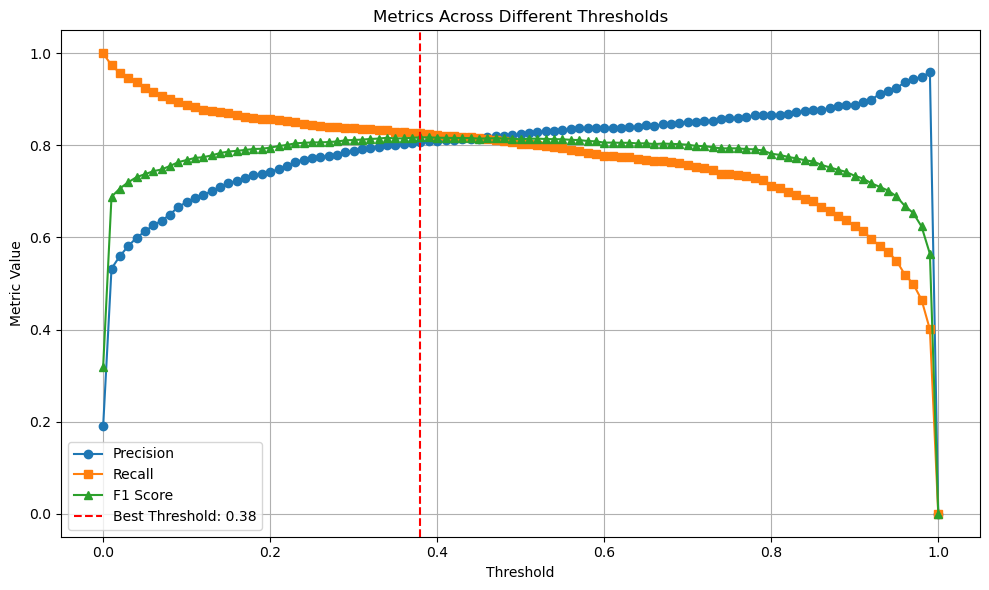


Evaluation Metrics with New Threshold:
Accuracy: 0.9298
Precision: 0.8079
Recall: 0.8276
F1 Score: 0.8176


In [394]:

def visualize_threshold_metrics(all_metrics):
    """
    Visualizes Precision, Recall, and F1 Score across different thresholds.

    Parameters:
        all_metrics (numpy array): Structured array with metrics for each threshold.
    """
    thresholds = all_metrics['threshold']
    precision = all_metrics['precision']
    recall = all_metrics['recall']
    f1 = all_metrics['f1']

    # Plot metrics across thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision, label='Precision', marker='o')
    plt.plot(thresholds, recall, label='Recall', marker='s')
    plt.plot(thresholds, f1, label='F1 Score', marker='^')
    plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')

    # Add titles and labels
    plt.title('Metrics Across Different Thresholds')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

def implement_new_threshold(model, X_test, threshold):
    """
    Generates predictions using the specified threshold.

    Parameters:
        model: Trained model with a predict_proba method.
        X_test (array): Test set features.
        threshold (float): Chosen classification threshold.

    Returns:
        y_pred_new (array): Predictions based on the new threshold.
    """
    # Predict probabilities for the positive class
    y_pred_proba = model.predict(X_test)

    # Apply the new threshold
    y_pred_new = (y_pred_proba >= threshold).astype(int)
    return y_pred_new

# Visualize metrics across thresholds
visualize_threshold_metrics(all_metrics)

# Implement new threshold in predictions
y_pred_new_threshold = implement_new_threshold(lgb_model, X_test_transformed, best_threshold)

# Evaluate new predictions
new_accuracy = accuracy_score(y_test, y_pred_new_threshold)
new_precision = precision_score(y_test, y_pred_new_threshold)
new_recall = recall_score(y_test, y_pred_new_threshold)
new_f1 = f1_score(y_test, y_pred_new_threshold)

# Display evaluation metrics for the new threshold
print("\nEvaluation Metrics with New Threshold:")
print(f"Accuracy: {new_accuracy:.4f}")
print(f"Precision: {new_precision:.4f}")
print(f"Recall: {new_recall:.4f}")
print(f"F1 Score: {new_f1:.4f}")


# Feature Importance

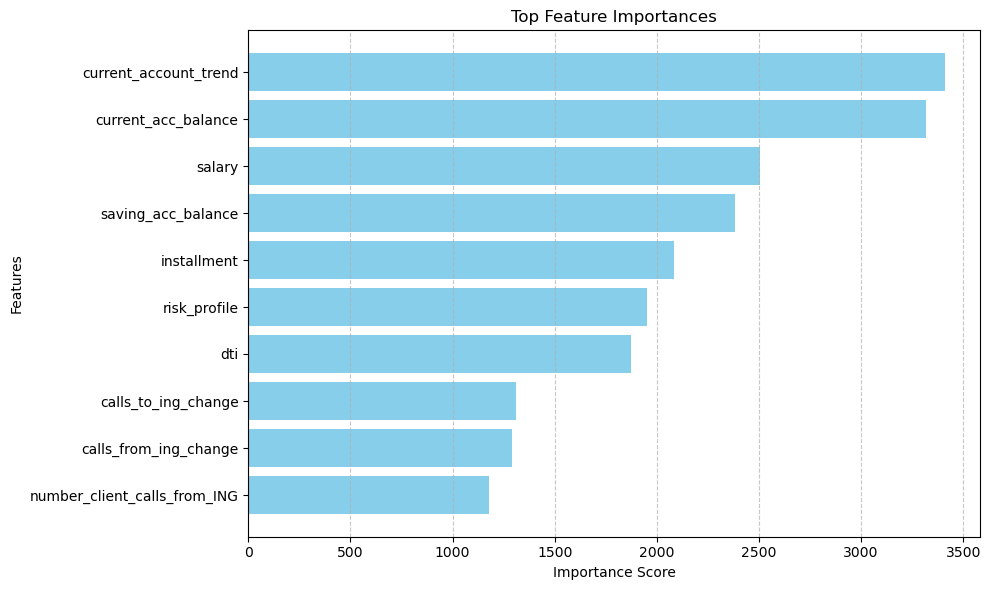

Top Feature Importances:
                         Feature  Importance
13         current_account_trend        3411
1            current_acc_balance        3317
0                         salary        2505
2             saving_acc_balance        2385
5                    installment        2082
11                  risk_profile        1951
12                           dti        1875
14           calls_to_ing_change        1309
15         calls_from_ing_change        1293
9   number_client_calls_from_ING        1179


In [395]:
# Generate full feature names after preprocessing
def get_full_feature_names(preprocessor, config):
    """
    Retrieve full feature names after preprocessing, including one-hot encoding columns.

    Parameters:
        preprocessor: Fitted ColumnTransformer.
        config (dict): Dictionary containing numerical and categorical feature names.

    Returns:
        list: Full list of feature names after transformation.
    """
    num_features = config['num_features']
    cat_features = config['cat_features']

    # Retrieve feature names for each transformer
    num_feature_names = preprocessor.named_transformers_['num'].get_feature_names_out(num_features)
    cat_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)

    # Combine numerical and categorical feature names
    return list(num_feature_names) + list(cat_feature_names)

# Fit the preprocessor and retrieve full feature names
preprocessor.fit(X_train)
full_feature_names = get_full_feature_names(preprocessor, feature_config)

# Validate the number of features
if len(full_feature_names) != lgb_model.num_feature():
    print(f"Warning: Feature names mismatch. Model expects {lgb_model.num_feature()} features.")

# Plot and retrieve feature importance
feature_importance_df = plot_feature_importance(lgb_model, full_feature_names, top_n=10)

# Display the top 10 features and their importance
print("Top Feature Importances:")
print(feature_importance_df)


# Feature Importance Interpretation

- Definition: Feature importance measures how much each feature contributes to the predictive performance of the model.
- Importance Scores: Higher importance scores indicate that the feature has a greater impact on the model's predictions.

In the output:

- current_account_trend has the highest importance score of 3411, making it the most influential feature for the model.
- current_acc_balance is the second most important feature with a score of 3317.
- Features like number_client_calls_from_ING (importance score 1179) have lower influence compared to the top-ranked features.

# Feature Ranking

- The DataFrame is sorted in descending order of feature importance. The first row (current_account_trend) is the most important, and the last row (number_client_calls_from_ING) among the top 10 features is the least important.

# Top Features

- The top_n=10 parameter limits the output to the top 10 features. These features are considered the most relevant for the model.

In practice, these top features can guide:

- Model Simplification: If a small subset of features is highly important, you may consider dropping less important features for simpler models.
- Domain Insights: The top features may offer insights into key factors influencing predictions in our dataset.

# Interpretation for Business or Domain

Let’s consider the specific features:

- current_account_trend being the most important suggests that a customer’s current account trend plays a critical role in the model’s predictions.
- salary and current_acc_balance are also highly impactful, indicating that financial status significantly affects the predictions.
- Features like number_client_calls_from_ING and calls_from_ing_change suggest that client interaction frequency is relevant, potentially reflecting behavioral aspects.

# Using the Insights

- Feature Engineering: Focus on refining or creating additional features related to current_account_trend, salary, or other high-ranking features.
- Business Decisions: Share these insights with stakeholders to prioritize data collection and analysis for the most impactful features.
- Explainability: Use these results to justify the model's decisions, improving trust and transparency.

/Users/yasirkeskin/anaconda3/lib/python3.10/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


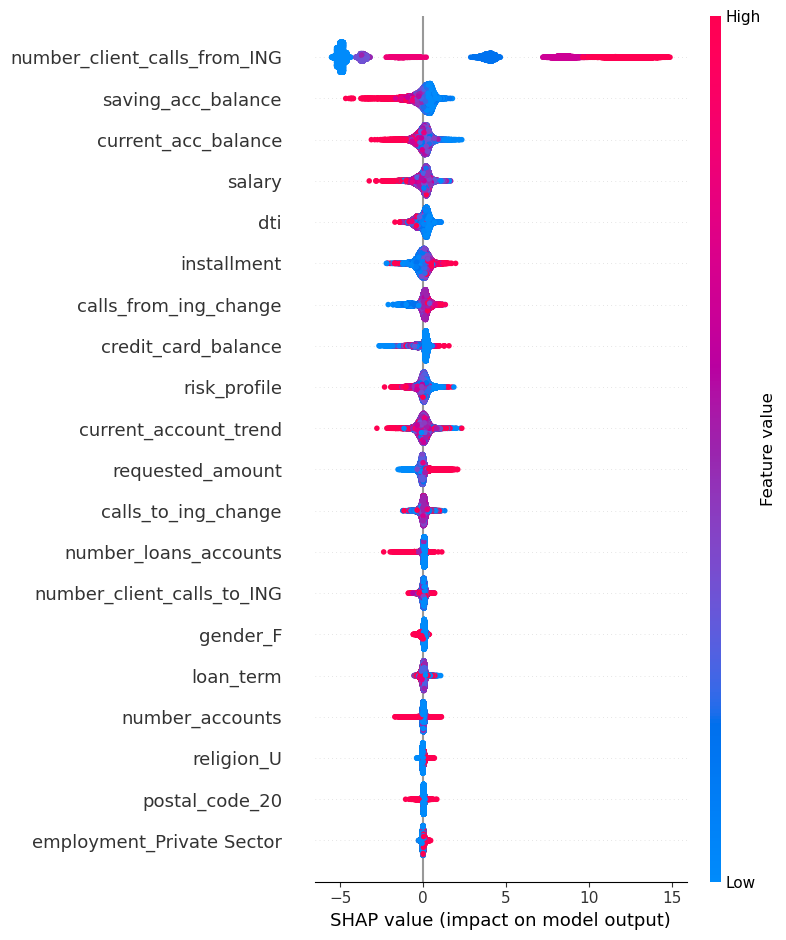

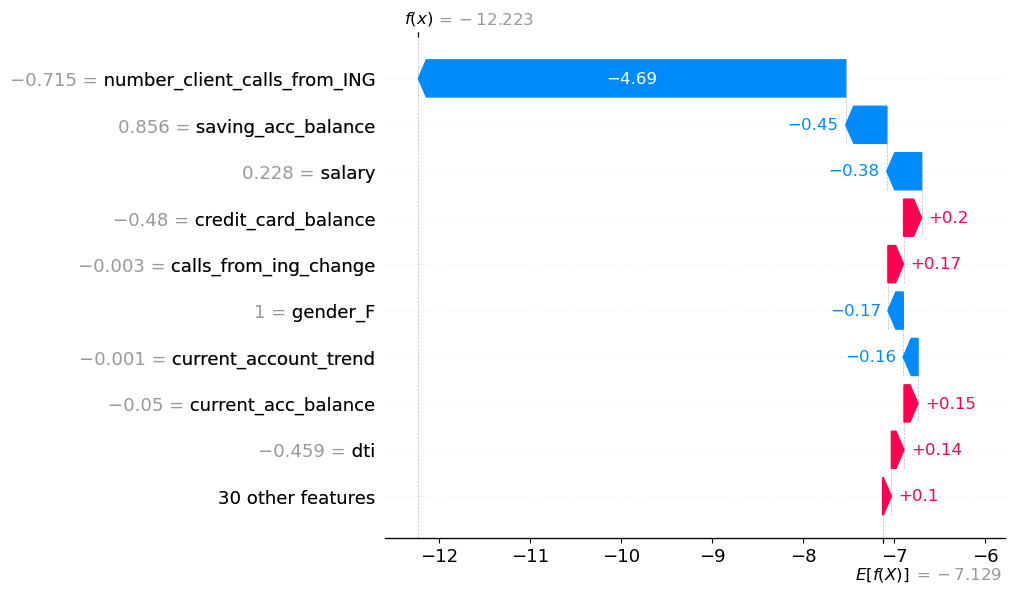

In [397]:
# 1. Initialize SHAP explainer
explainer = shap.TreeExplainer(lgb_model)

# 2. Compute SHAP values
shap_values = explainer.shap_values(X_train_transformed)

# 3. Generate visualizations
# Overall feature importance
shap.summary_plot(shap_values, X_train_transformed, feature_names=full_feature_names)


# Fix for binary classification
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],  # Use the first instance's SHAP values
        base_values=explainer.expected_value,  # Base value for log-odds
        data=X_train_transformed[0],  # Feature values for the first instance
        feature_names=full_feature_names
    )
)


Calculating the Final Log-Odds:
Now, let's calculate the final log-odds by adding up all the contributions:

Final Log-Odds
=
Base Value
+
Feature Contributions
Final Log-Odds=Base Value+Feature Contributions
Final Log-Odds
=
−
7.129
-
4.69
-
0.45
−
0.38
+
0.20
+
0.15
−
0.17
−
0.16
+
0.15
+
0.14
Final Log-Odds=−7.129-4.69-0.45-0.38+0.20+0.15−0.17−0.16+0.15+0.14..
Final Log-Odds
=
−
12.22
Final Log-Odds=−12.22

# Interpretation Summary:


- Log-Odds: The final log-odds prediction for this instance is -12.34, which strongly favors the negative class.

Key Drivers:

- The number of client calls from ING (negative) and salary (negative) are the main features pushing the model towards the negative class.
- Credit card balance, calls from ING change, and other features like loan term and requested amount push the prediction towards the positive class.
- Other features like employment and loan reason have a minor impact, either slightly reducing the likelihood of the negative class or not contributing significantly.

# Model Training with Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning

def train_lightgbm_with_cv(X_train, y_train, X_test, y_test, param_grid, nfold=3):
    """
    Trains a LightGBM classifier with hyperparameter tuning using cross-validation and evaluates it on the test set.

    Parameters:
        X_train (array): Preprocessed training features.
        y_train (pd.Series): Training target.
        X_test (array): Preprocessed testing features.
        y_test (pd.Series): Testing target.
        param_grid (dict): Hyperparameter grid for tuning.
        nfold (int): Number of folds for cross-validation.

    Returns:
        model (lgb.Booster): Trained LightGBM model.
        metrics (dict): Evaluation metrics for the model.
        best_params (dict): Best hyperparameters.
    """
    # Prepare LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)

    # Set initial parameters
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'metric': 'auc',
        'random_state': 42,
        'n_jobs': -1
    }

    # Perform cross-validation to find best hyperparameters
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000,
        nfold=nfold,
        stratified=True
    )

    # Print available keys in cv_results to debug
    print("Available keys in cv_results:", cv_results.keys())
    print("First few entries of cv_results:", {key: cv_results[key][:5] for key in cv_results})

    # Dynamically choose the best metric key based on available ones
    best_metric = 'valid auc-mean' if 'valid auc-mean' in cv_results else None

    if best_metric is None:
        raise KeyError(f"No suitable metric found in cv_results. Available keys: {cv_results.keys()}")

    # Select the best number of boosting rounds based on the chosen metric
    best_num_boost_round = len(cv_results[best_metric])

    # Train the model using the best number of boosting rounds
    model = lgb.train(
        params,
        train_data,
        num_boost_round=best_num_boost_round
    )

    # Predict on the test set
    y_pred = (model.predict(X_test) > 0.5).astype(int)  # Threshold of 0.5 for binary classification
    y_pred_proba = model.predict(X_test)

    # Evaluate the model
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba)
    }

    # Return model, metrics, and best params (from cv)
    best_params = params
    return model, metrics, best_params

# Example usage:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, 15],
    'num_leaves': [31, 63, 127],
    'n_estimators': [100, 200, 300]
}

# Train the model with cross-validation-based hyperparameter tuning
lgb_model, evaluation_metrics, best_params = train_lightgbm_with_cv(
    X_train_transformed, y_train, X_test_transformed, y_test, param_grid
)

# Display the evaluation metrics
print("Model Evaluation Metrics:")
for metric, value in evaluation_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nBest Hyperparameters from Cross-Validation:")
print(best_params)


[LightGBM] [Info] Number of positive: 3958, number of negative: 15563
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 19521, number of used features: 39
[LightGBM] [Info] Number of positive: 3958, number of negative: 15563
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2009
[LightGBM] [Info] Number of data points in the train set: 19521, number of used features: 39
[LightGBM] [Info] Number of positive: 3958, number of negative: 15564
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing wa

# After Hyperparameter Tuning

## Training Details

Number of Positives and Negatives:

- The training data is imbalanced, with ~20% positives and ~80% negatives (pavg=0.2027).
- This imbalance is reflected in the initial scores (initscore), which LightGBM adjusts to balance predictions during training.

Row-wise Multi-threading:

- LightGBM auto-selected row-wise multi-threading to optimize speed. The testing overhead for this decision was minimal (~0.0005 seconds).
- Alternative: You can explicitly set force_row_wise=true to bypass this step or use force_col_wise=true if memory usage is a concern.
Bins and Features:

- Total bins: 2009 (reflecting how continuous features were discretized).
- Number of features used: 39 (indicating no features were dropped or excluded).

## Cross-Validation (CV) Results

Keys in cv_results:

- valid auc-mean: Mean AUC score across CV folds for validation data.
- valid auc-stdv: Standard deviation of AUC scores, indicating variability across folds.

AUC Performance:

- High AUC mean values (~0.971): This suggests the model is highly effective at distinguishing between positive and negative classes.
- Low AUC standard deviations (~0.001): The model performs consistently across CV folds, reflecting robust performance.

## Model Evaluation Metrics

These metrics are computed on the test dataset (not CV splits):

Metric	Value	Interpretation
- Accuracy	0.9299	~93% of predictions were correct, but accuracy might be misleading due to class imbalance.
- Precision	0.8239	~82% of positive predictions are correct.
- Recall	0.8032	~80% of actual positives were correctly identified by the model.
- F1 Score	0.8134	A harmonic mean of precision and recall; balanced performance in handling positives.
- ROC AUC	0.9689	Excellent discriminative ability; the model separates positives from negatives very effectively.

## Best Hyperparameters

The best hyperparameters from tuning are:

- Objective: binary (binary classification task).
- Boosting Type: gbdt (Gradient Boosting Decision Tree, the default boosting method in LightGBM).
- Metric: auc (Area Under the Curve, used for evaluation during tuning).
- Random State: 42 (ensures reproducibility of results).
- n_jobs: -1 (utilizes all CPU cores for faster computation).


## Insights and Recommendations

High Model Performance:

- The model shows excellent performance with high AUC (0.9689) and balanced F1 (0.8134), indicating it is both effective and consistent.
- Precision and recall are also reasonably high, reflecting good handling of class imbalance.

Handling Class Imbalance:

- Despite class imbalance, the metrics are not overly skewed. Techniques such as scale_pos_weight (not explicitly mentioned here but potentially used) or careful sampling during CV likely helped.

Next Steps:

- Feature Importance: Examine feature importance to identify key predictors.
- Error Analysis: Review false positives/negatives to uncover patterns and potential improvements.
- Threshold Adjustment: Adjust the decision threshold to balance precision and recall based on business needs.

Deployment Ready:

- With high ROC AUC and consistent results across folds, the model is suitable for deployment.
- Ensure robust monitoring post-deployment to detect data drift or performance degradation.


In [ ]:
def save_model(model, filepath):
    """
    Saves the trained model to a file for future use.

    Parameters:
    - model: Trained model to save
    - filepath: Path where to save the model
    """
    try:
        # Save the model to a .pkl file
        joblib.dump(model, filepath)
        print(f"Model saved successfully to {filepath}")
    except Exception as e:
        print(f"Error during model saving: {e}")

# Example usage
save_model(lgb_model, 'final_lightgbm_model.pkl')


Model saved successfully to final_lightgbm_model.pkl
